In [1]:
!rm -r /kaggle
!rm -r /input

rm: cannot remove '/kaggle/input': Device or resource busy
rm: cannot remove '/input': No such file or directory


In [2]:
!mkdir /input
!mkdir /kaggle
!mkdir /kaggle/working

mkdir: cannot create directory ‘/kaggle’: File exists


In [3]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.9 MB/s eta 0:00:00


In [4]:
import os
from google.colab import files

files.upload()

dataset = 'lfw-dataset'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/lfw-dataset

zip_file = f"{dataset}.zip"
destination_dir = f"../input/lfw-dataset"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle (1).json to kaggle (1).json
rm: cannot remove 'lfw-dataset': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 93% 105M/112M [00:01<00:00, 99.4MB/s] 
100% 112M/112M [00:01<00:00, 78.9MB/s]


In [5]:

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

In [6]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index", axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

825
837


<Axes: xlabel='name'>

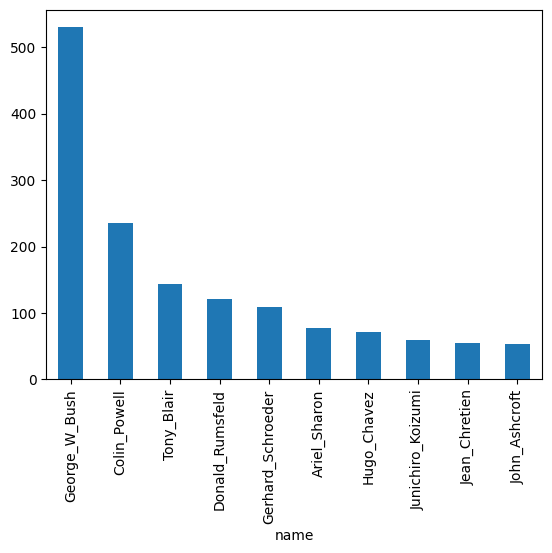

In [7]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [8]:
image_paths['name'].value_counts()[:10]

name
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64

In [9]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75),
                        image_paths[image_paths.name=="Hugo_Chavez"].sample(71),
                        image_paths[image_paths.name=="Junichiro_Koizumi"].sample(60),
                        image_paths[image_paths.name=="Jean_Chretien"].sample(55),
                        image_paths[image_paths.name=="John_Ashcroft"].sample(53)
                        ]
                       )

In [10]:
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [11]:

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))

In [12]:
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are training on several classes, we need several classification units (one for each class). We also use a
# softmax activation function
multi_classifier.add(Dense(units = 10, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')




Moved 440 images to train_multi/ folder.
Moved 111 images to val_multi/ folder.
Moved 138 images to test_multi/ folder.
Found 440 images belonging to 10 classes.
Found 111 images belonging to 10 classes.
Found 138 images belonging to 10 classes.


In [13]:
print(len(multi_training_set.filepaths))

440


In [14]:
multi_history = multi_classifier.fit(multi_training_set,
                                            epochs = 50,
                                            validation_data = multi_val_set,
                                            batch_size=32
                                     )

Epoch 1/50
14/14 [==============================] - 12s 421ms/step - loss: 16.9968 - accuracy: 0.1364 - val_loss: 5.4286 - val_accuracy: 0.2342
Epoch 2/50
14/14 [==============================] - 7s 532ms/step - loss: 3.4866 - accuracy: 0.1455 - val_loss: 2.4974 - val_accuracy: 0.1892
Epoch 3/50
14/14 [==============================] - 6s 416ms/step - loss: 2.2008 - accuracy: 0.2000 - val_loss: 2.3262 - val_accuracy: 0.2162
Epoch 4/50
14/14 [==============================] - 6s 405ms/step - loss: 2.1644 - accuracy: 0.2386 - val_loss: 2.3236 - val_accuracy: 0.1892
Epoch 5/50
14/14 [==============================] - 8s 577ms/step - loss: 2.0706 - accuracy: 0.2818 - val_loss: 2.2616 - val_accuracy: 0.2523
Epoch 6/50
14/14 [==============================] - 6s 411ms/step - loss: 1.9174 - accuracy: 0.3636 - val_loss: 2.2739 - val_accuracy: 0.2072
Epoch 7/50
14/14 [==============================] - 7s 527ms/step - loss: 1.6780 - accuracy: 0.4318 - val_loss: 2.1322 - val_accuracy: 0.3333
Epoc

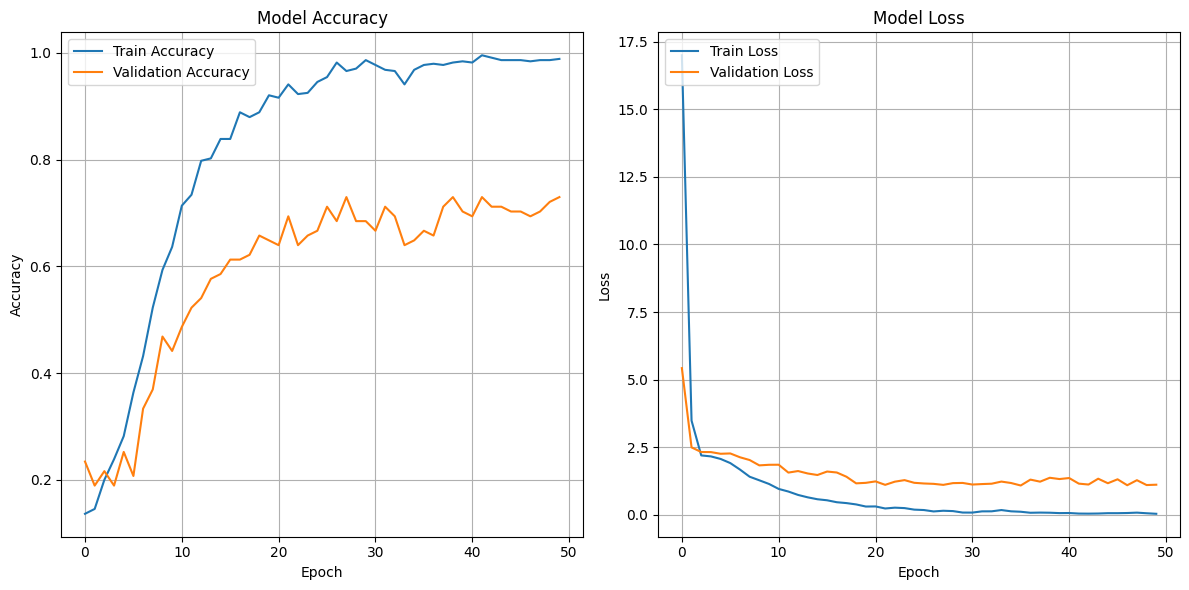

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(multi_history.history['accuracy'], label='Train Accuracy')
plt.plot(multi_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(multi_history.history['loss'], label='Train Loss')
plt.plot(multi_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


In [37]:
from keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(250, 250))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # rescale the image to match the rescaling done during training
    return img_array

Saving Screenshot 2024-05-30 030559.png to Screenshot 2024-05-30 030559.png
1/1 [==============================] - 0s 18ms/step


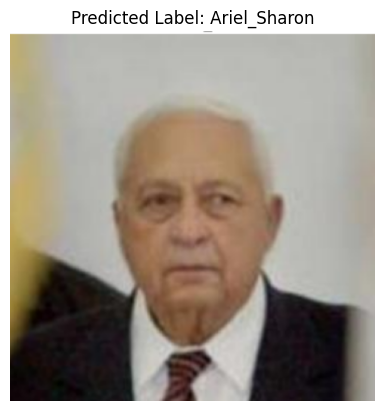

Predicted label: Ariel_Sharon


In [45]:
from google.colab import files
from PIL import Image
uploaded = files.upload()

labels = list(multi_test_set.class_indices.keys())

for filename in uploaded.keys():
    input_image = Image.open(filename)
    plt.imshow(input_image)
    plt.axis('off')  # Disable axis

    preprocessed_image = preprocess_image(filename)
    prediction = multi_classifier.predict(preprocessed_image)
    predicted_index = np.argmax(prediction, axis=1)[0]


    predicted_label = labels[predicted_index]
    plt.title(f'Predicted Label: {predicted_label}')
    plt.show()
    print(f'Predicted label: {predicted_label}')
